# Image segmentation with a simulated image

As usual, we begin with some imports.

In [1]:
import warnings

from astropy.convolution import convolve
from astropy.stats import sigma_clipped_stats, gaussian_sigma_to_fwhm
from astropy.table import QTable
from astropy.visualization import simple_norm, SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

import matplotlib.pyplot as plt
import numpy as np

from photutils.aperture import CircularAperture, EllipticalAperture
from photutils.centroids import centroid_2dg
from photutils.datasets import make_100gaussians_image, make_gaussian_sources_image, make_noise_image
from photutils.detection import find_peaks, DAOStarFinder
from photutils.segmentation import detect_sources, make_2dgaussian_kernel, SourceCatalog
from photutils.utils import make_random_cmap

plt.style.use('../photutils_notebook_style.mplstyle')

## More about image segmentation using a small example 

Before diving into an applicatino of image segmentation to a simulated image, some more description of the technique may be helpful. We contruct a small imge 10 pixels on a side. We will start with some noise and add set the value in several pixels well above the standard deviation of the noise.

In [2]:
# Make the noise
std_dev = 5
image = make_noise_image([10, 10], stddev=std_dev, mean=0)

# Make a source smaller than the image
source = np.array(
    [
        [1, 2, 3, 1],
        [1, 0.5, 2, 3],
        [1, 3, 2, 1],
        [0, 2, 1, 0]
    ]
)

# Make sure the source pixels are much larger than the background
source = 10.0 * std_dev * source

# Put one source in the upper left...
image[1:5, 0:4] += source
# ...and one source in the lower right, and transpose it to make it look different
image[-5:-1, -4:] += source.T

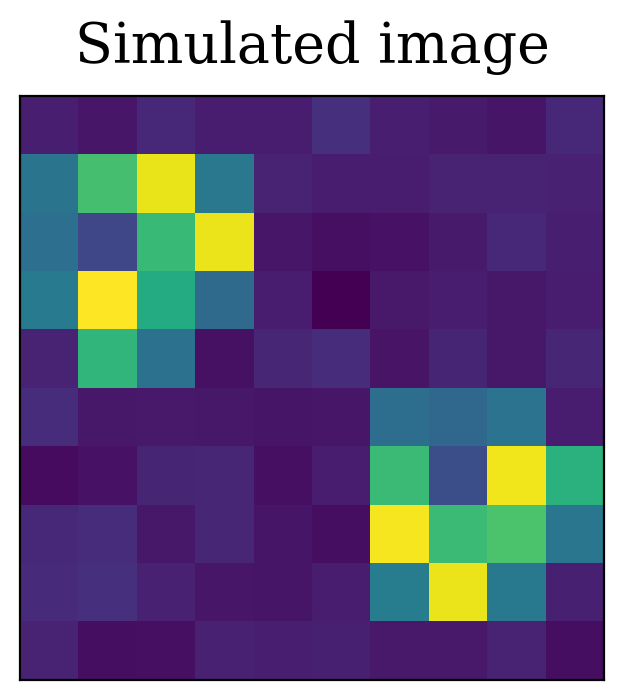

In [3]:
plt.figure(figsize=(4, 4))
plt.imshow(image, cmap="viridis")

plt.title("Simulated image")
# Suppress tick labels
plt.xticks([])
plt.yticks([]);

Now we create a detection image, called `detected_image` below, in which all pixels with value larger than 3 times the standard deviation are set to one, and the rest set to zero. In this example, the detect pixels fall into one of two connected groups, by construction.

This detection is shown below, with the pixels in the two sources labeled by either "1" or "2" and the rest of the pixels labeled "0".

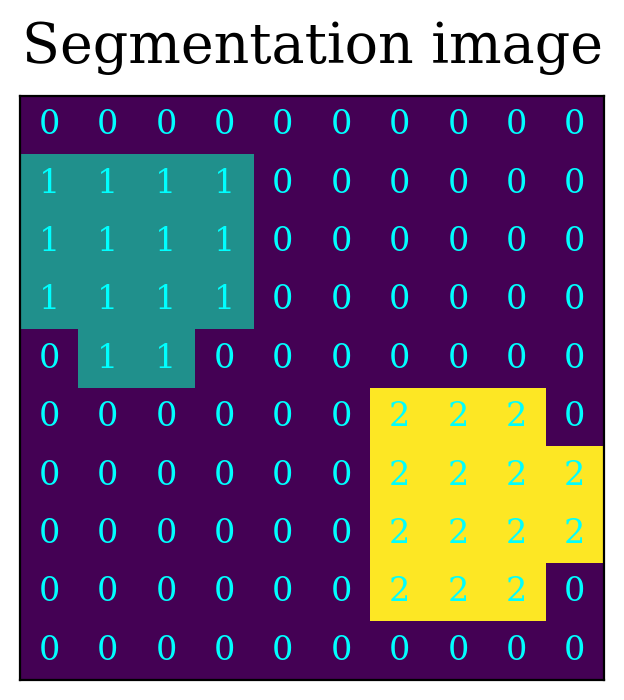

In [4]:
source_pixels = image > 3 * std_dev
detected_image = image.copy()
detected_image[~source_pixels] = 0
# This intiially labels all sources with the same number, 1
detected_image[source_pixels] = 1 

# The sources were added in a way that makes it easy to separate the sources,
# so number the source in the lower right 2
detected_image[5:, 5:] *= 2


plt.figure(figsize=(4, 4))
plt.imshow(detected_image, cmap="viridis")

for x in range(10):
    for y in range(10):
        plt.annotate(f"{detected_image[y, x]:.0f}", (x, y), va="center", ha="center", color="cyan")
plt.xticks([])
plt.yticks([])
plt.title("Segmentation image");

That, in a nutshell, is image segmentation. The implementation is more complicated than what is done above, and the image is typically convolved with a filter before doing the segmentation, but the gist of the method is straightforward.

## Image segmentation with a larger image

We again consider the simulated image with 100 Gaussian sources that was introduced in [background removal with a simulated image](01.01.01-Background-removal-simulated-data.ipynb)

To begin, let's create the image and subtract the background. Recall that this image contains a mix of star-like object and more extended sources, and the sigma clipped median does a reasonable job of estimating the background.

In [5]:
data = make_100gaussians_image()
mean, med, std = sigma_clipped_stats(data, sigma=3.0, maxiters=5)
data_subtracted = data - med

### Settings for image segmentation

There are a few settings we need to make before detecting sources with iumage segmentation using the [`photutils`](https://photutils.readthedocs.io/en/stable/) function [`detect_sources`](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.detect_sources.html#photutils.segmentation.detect_sources):

+ Full-width half-maximum (FWHM) of the typical source in the image, represented by`fwhm` in the code below. This is used to smooth the image before performing the segmentation.
+ Threshold for a pixel to count as part of a source, typically expressed as a multiple of the standard deviation in the image and represented below by `threshold`.
+ Number of adjacent pixels above the threshold to count as a source, represented by `npixels` below.
+ Size of the kernel used for smoothing, represented by `kernel_size` below.

In [6]:
# Define threshold and minimum object size
threshold = 3. * std
npixels = 10
fwhm = 3
kernel_size = 5

With those settings out of the way, there are three steps to the detection:

1. Create the smoothing kernel.
2. Apply the smoothing by convolving the kernel with the original image.
3. Perform image segmentation on the convovled image.

In [7]:
# Make the kernel
kernel = make_2dgaussian_kernel(fwhm, size=kernel_size)

# Make a convolved image
convolved_data = convolve(data_subtracted, kernel)

# Create a segmentation image from the convolved image
segm = detect_sources(convolved_data, threshold, npixels)

print('Found {} sources'.format(segm.max_label))

Found 83 sources


The 82 sources found here is the closest we have yet come to detecting all 100 sources that are in this image.

## Why find peaks here??

The original image, convolved image and segmentation image are shown below. Each color in the segmentation image represents a different source. The color map for this case is part of the [`SegmentationImage`](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.SegmentationImage.html#photutils.segmentation.SegmentationImage) generated by [`detect_sources`](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.detect_sources.html#photutils.segmentation.detect_sources).

Text(0.5, 1.0, 'Segmentation Map')

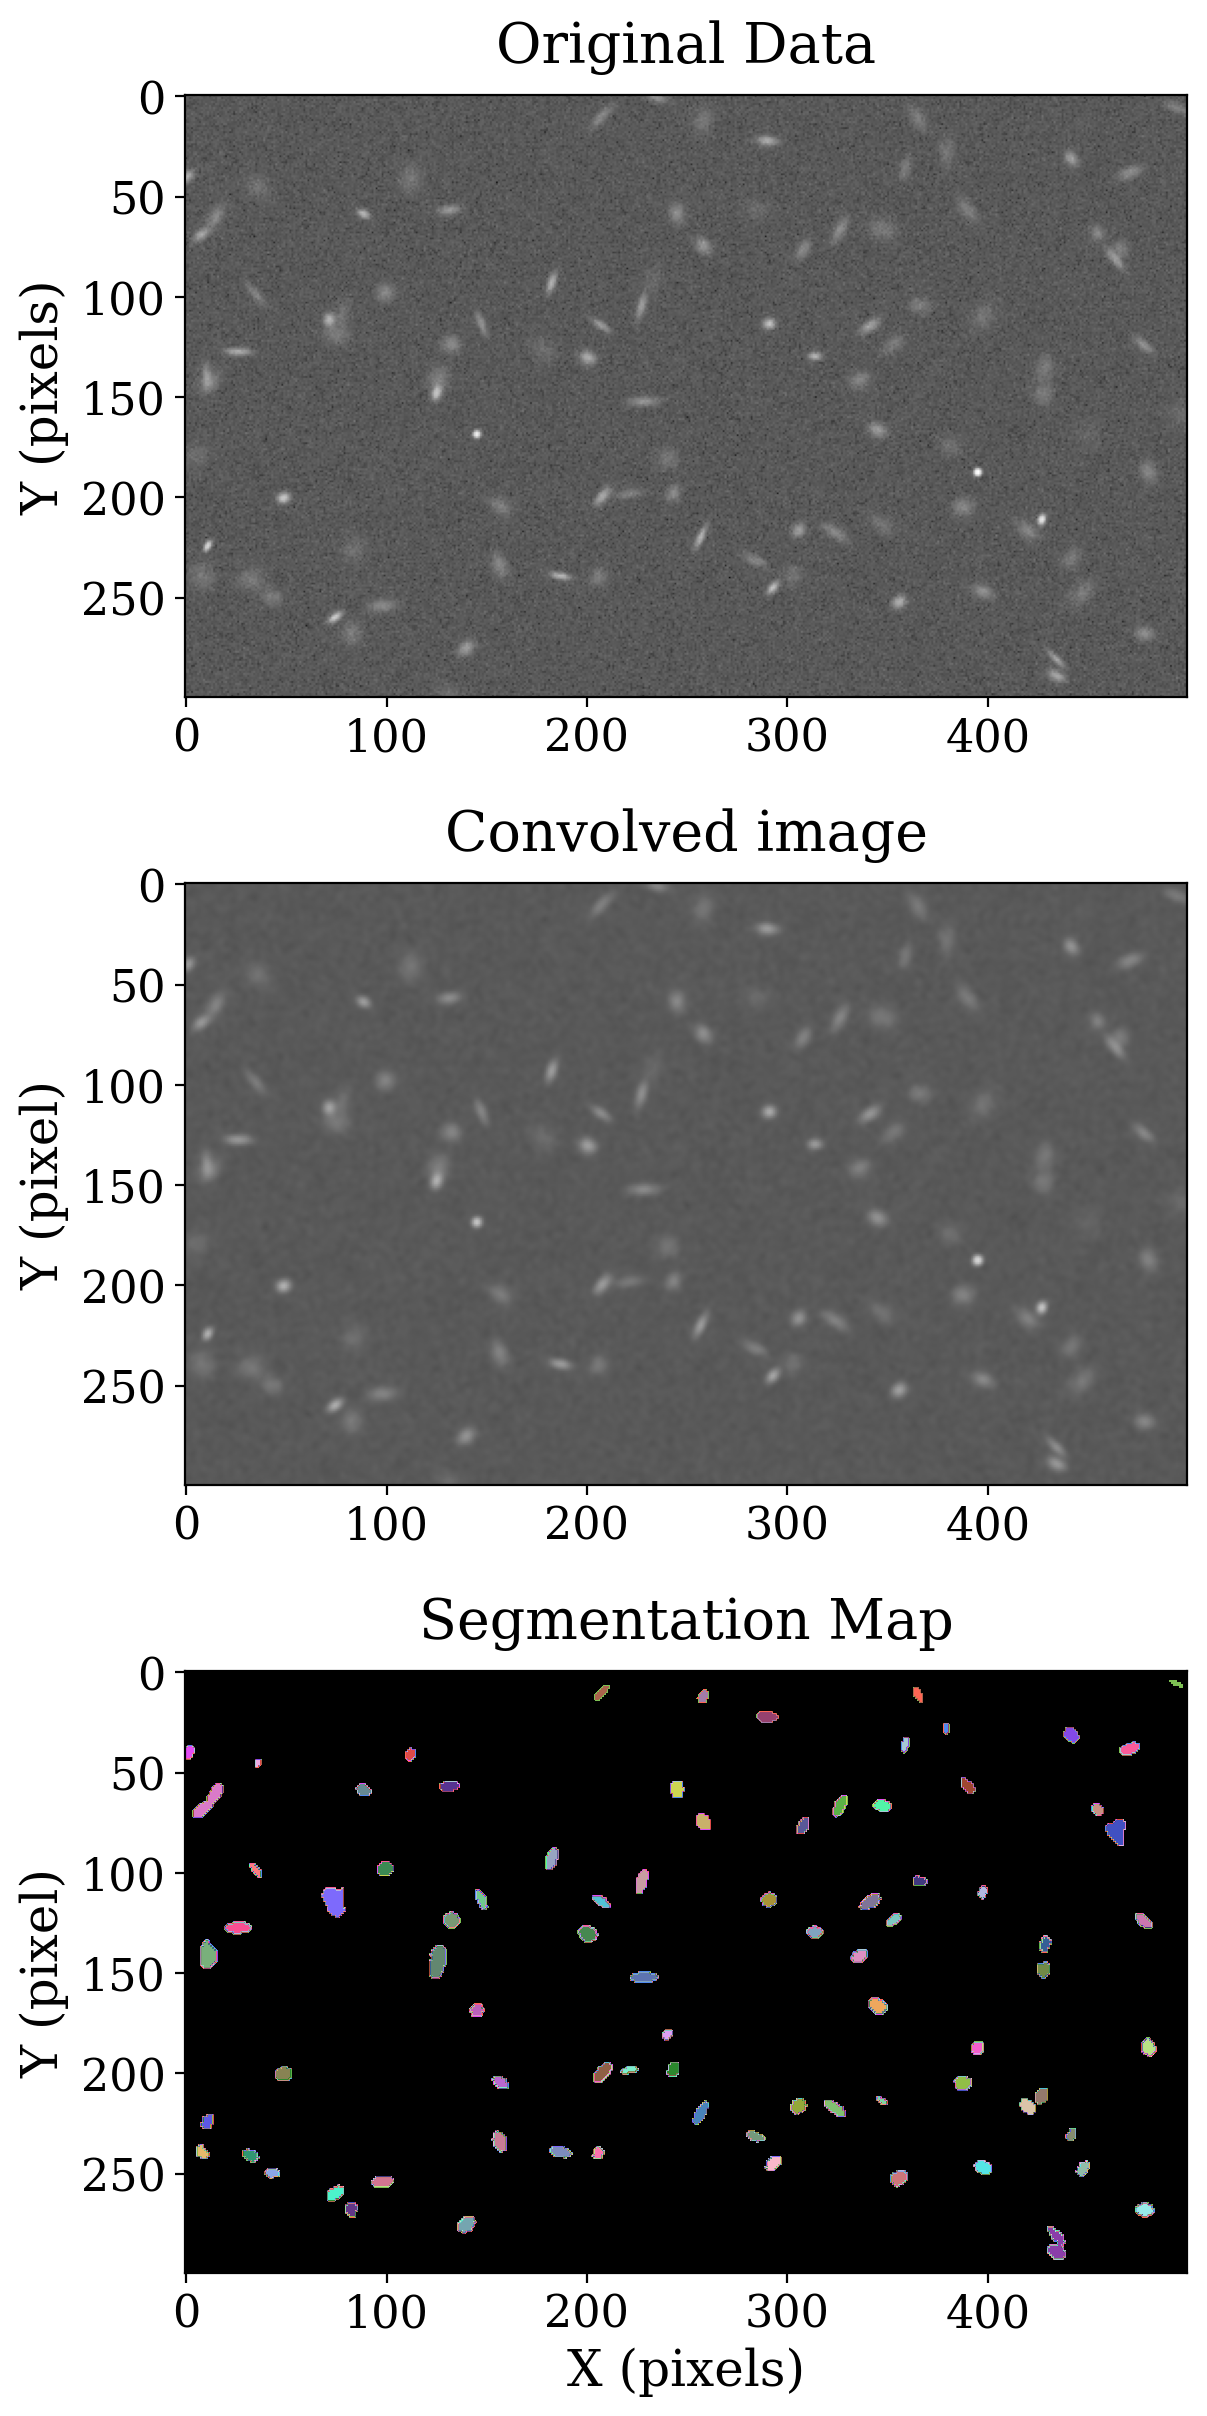

In [8]:
# Set up the figure with subplots
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(6, 12))
plt.tight_layout()

# Plot the data
# Set up the normalization and colormap
norm_image = ImageNormalize(stretch=SqrtStretch())

# Plot the original data
fitsplot = ax1.imshow(data_subtracted,
                      norm=norm_image, cmap='Greys_r')
ax1.set_ylabel('Y (pixels)')
ax1.set_title('Original Data')

# Plot to convolved data
convolved_plot = ax2.imshow(convolved_data, cmap="Greys_r", norm=norm_image)
ax2.set_ylabel("Y (pixel)")
ax2.set_title("Convolved image")

# Plot the segmentation image
rand_cmap = make_random_cmap(seed=12345)
rand_cmap.set_under('black')
segplot = ax3.imshow(segm, vmin=1, cmap=segm.cmap)
ax3.set_ylabel("Y (pixel)")
ax3.set_xlabel('X (pixels)')
ax3.set_title('Segmentation Map')

Much more information about the segmentation sources can be calculated using the [SourceCatalog](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.SourceCatalog.html#photutils.segmentation.SourceCatalog) from [`photutils`](https://photutils.readthedocs.io/en/stable/). This object will be discussed in more detail in the next notebook. For now we use it to construct apertures for source in the segmentation image that will be used when we compare image segmentation to the other source detection methods we have discussed.

In [9]:
catalog = SourceCatalog(data_subtracted, segm)
table = catalog.to_table()

# Define the approximate isophotal extent
r = 4.  # pixels

# Create the apertures
apertures = []
for obj in catalog:
    position = (obj.xcentroid, obj.ycentroid)
    a = obj.semimajor_sigma.value * r
    b = obj.semiminor_sigma.value * r
    theta = obj.orientation
    apertures.append(EllipticalAperture(position, a, b, theta=theta))

## Comparing Detection Methods

Let's compare how image segmentation compares to using [`DAOStarFinder`](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html#photutils.detection.DAOStarFinder) and [`find_peaks`](https://photutils.readthedocs.io/en/stable/api/photutils.detection.find_peaks.html#photutils.detection.find_peaks) on this image.


In [10]:
# Detect sources with DAOFIND
daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold) 
sources_dao = daofind(data_subtracted)

In [11]:
# Detect sources with find_peaks
with warnings.catch_warnings(action="ignore"):
    sources_findpeaks = find_peaks(data_subtracted,
                                   threshold=5. * std, box_size=29,
                                   centroid_func=centroid_2dg)

In [12]:
print(f'''DAOStarFinder: {len(sources_dao)} sources
find_peaks: {len(sources_findpeaks)} sources
segmentation: {len(apertures)} sources''') 

DAOStarFinder: 134 sources
find_peaks: 71 sources
segmentation: 83 sources


A graph of the source locations is helpful.

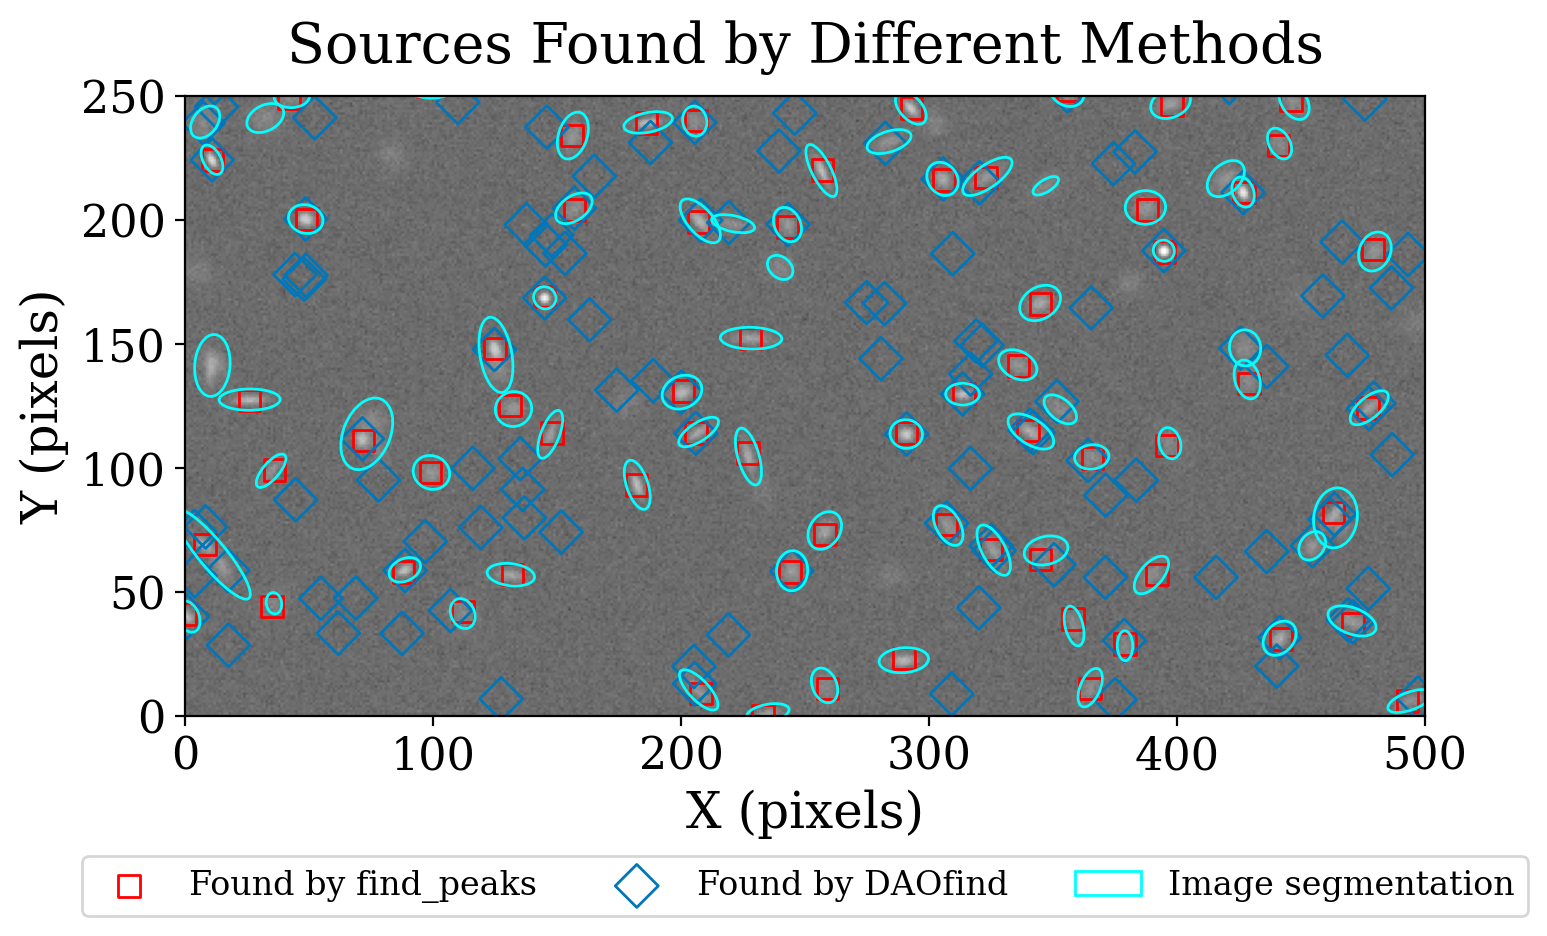

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# Plot the data
fitsplot = ax1.imshow(data, norm=norm_image, cmap='Greys_r', origin='lower')

marker_size = 60
ax1.scatter(sources_findpeaks['x_peak'], sources_findpeaks['y_peak'], s=marker_size, marker='s',
            lw=1, alpha=1, facecolor='None', edgecolor='r', label='Found by find_peaks')
ax1.scatter(sources_dao['xcentroid'], sources_dao['ycentroid'], s=2 * marker_size, marker='D',
            lw=1, alpha=1, facecolor='None', edgecolor='#0077BB', label='Found by DAOfind')

# Plot the apertures
apertures[0].plot(color='cyan', lw=1, alpha=1, axes=ax1, label="Image segmentation")
for aperture in apertures[1:]:
    aperture.plot(color='cyan', lw=1, alpha=1, axes=ax1)
    
# Add legend
ax1.legend(ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.35))

# Set the limits to avoid whitespace around the image
ax1.set_xlim(0, 500)
ax1.set_ylim(0, 250)

ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax1.set_title('Sources Found by Different Methods');

## Summary

Image segmentation identified more of the sources in this test image than either [`find_peaks`](https://photutils.readthedocs.io/en/stable/api/photutils.detection.find_peaks.html#photutils.detection.find_peaks) or [`DAOStarFinder`](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html#photutils.detection.DAOStarFinder). The latter wasn't expected to work well on this image because there is a large variety of source shapes and sizes. The undetected sources look relatively large and faint. Experimenting with the segmentation parameters would likely improve the detection.